Реализовать с помощью `Numpy` класс `MyMLP`, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

1. Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
2. Обеспечивать выбор следующих функции активации в рамках каждого слоя: `ReLU`, `sigmoid`, `linear`.
3. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
4. В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
5. Поддерживать использование `l1`, `l2` и `l1l2` регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций)


In [30]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical 
from IPython.display import Markdown, display

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# преобразуем данные в форму (N, 784), так как каждое изображение 28x28
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Преобразование меток в one-hot encoding (10 классов)
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)


In [31]:

class MyMLP:
    def __init__(self, layer_sizes, activation_functions,
                 task_type="regression", num_classes=None,
                 regularization=None, lambda_reg=0.01):
        self.layer_sizes        = layer_sizes
        self.activation_functions = activation_functions
        self.task_type          = task_type
        self.num_classes        = num_classes
        self.regularization     = regularization
        self.lambda_reg         = lambda_reg

        self.weights, self.biases = [], []
        self.activations, self.derivatives = [], []
        self._initialize_weights()

    def _initialize_weights(self):
        for nin, nout in zip(self.layer_sizes[:-1], self.layer_sizes[1:]):
            self.weights.append(np.random.randn(nin, nout) * 0.01)
            self.biases .append(np.zeros((1, nout)))

    def _activation(self, z, kind):
        if kind == 'relu':
            return np.maximum(0, z)
        if kind == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        if kind == 'linear':
            return z
        if kind == 'softmax':
            z_shift = z - np.max(z, axis=1, keepdims=True)
            ez = np.exp(z_shift)
            return ez / np.sum(ez, axis=1, keepdims=True)
        raise ValueError("Unknown activation")

    def _activation_derivative(self, a, kind):
        # a – уже вычисленная активация (shape: [m, n])
        if kind == 'relu':
            return (a > 0).astype(float)
        if kind == 'sigmoid':
            return a * (1 - a)
        if kind == 'linear':
            return np.ones_like(a)

        if kind == 'softmax':                       
            m, n = a.shape
            J = np.zeros((m, n, n), dtype=a.dtype)
            for i in range(m):
                s = a[i][:, None]                  # (n,1)
                J[i] = np.diagflat(s) - s @ s.T    
            return J

        raise ValueError("Unknown activation")

    def forward(self, X):
        self.activations = [X]
        for i in range(len(self.layer_sizes) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            a = self._activation(z, self.activation_functions[i])
            self.activations.append(a)
        return self.activations[-1]

    def compute_loss(self, Y_pred, Y_true):
        if self.task_type == "regression":
            return np.mean((Y_pred - Y_true) ** 2)

        eps = 1e-15
        if self.num_classes == 2:
            return -np.mean(Y_true * np.log(Y_pred + eps) +
                            (1 - Y_true) * np.log(1 - Y_pred + eps))
        return -np.mean(np.sum(Y_true * np.log(Y_pred + eps), axis=1))

    def backpropagate(self, X, Y):
        m = X.shape[0]
        Y_pred = self.forward(X)
        dZ = Y_pred - Y                           

        self.derivatives = []
        # слои L-1 … 0
        for i in range(len(self.layer_sizes) - 2, -1, -1):
            a_prev = self.activations[i]
            dW = (a_prev.T @ dZ) / m
            db = np.sum(dZ, axis=0, keepdims=True) / m
            self.derivatives.append((dW, db))

            if i == 0:                    # дошли до входа
                break

            dZ_prev = dZ @ self.weights[i].T
            act_prev = self.activation_functions[i-1]

            if act_prev == 'softmax':     
                J = self._activation_derivative(self.activations[i], 'softmax')
                # einsum: (m,n,n)·(m,n)→(m,n)
                dZ = np.einsum('ijk,ik->ij', J, dZ_prev)
            else:
                phi_prime = self._activation_derivative(self.activations[i], act_prev)
                dZ = dZ_prev * phi_prime

        self.derivatives.reverse()

    def apply_gradients(self, lr):
        for i, (dW, db) in enumerate(self.derivatives):
            if self.regularization == 'L2':
                dW += self.lambda_reg * self.weights[i]
            elif self.regularization == 'L1':
                dW += self.lambda_reg * np.sign(self.weights[i])
            elif self.regularization == 'L1L2':
                dW += self.lambda_reg * (np.sign(self.weights[i]) + self.weights[i])

            self.weights[i] -= lr * dW
            self.biases[i]  -= lr * db

    def fit(self, X, Y, epochs=100, batch_size=32, learning_rate=0.01):
        for epoch in range(epochs):
            for start in range(0, X.shape[0], batch_size):
                X_b = X[start:start + batch_size]
                Y_b = Y[start:start + batch_size]
                self.backpropagate(X_b, Y_b)
                self.apply_gradients(learning_rate)

            if epoch % 10 == 0:
                loss = self.compute_loss(self.forward(X), Y)
                print(f"Epoch {epoch:3d}  Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward(X)

In [32]:
# Инициализация модели для классификации MNIST (10 классов)
model = MyMLP(layer_sizes=[784, 128, 10], activation_functions=['sigmoid', 'softmax'], task_type='classification', num_classes=10)

# Обучение модели
model.fit(X_train, Y_train, epochs=100, batch_size=32, learning_rate=0.01)
Y_pred = model.predict(X_test)

# Переводим предсказания в метки классов
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Рассчитываем точность
accuracy = np.mean(Y_pred_classes == Y_true_classes)
print(f'Accuracy: {accuracy * 100:.2f}%')

Epoch   0  Loss: 2.0526
Epoch  10  Loss: 0.3398
Epoch  20  Loss: 0.2782
Epoch  30  Loss: 0.2438
Epoch  40  Loss: 0.2164
Epoch  50  Loss: 0.1934
Epoch  60  Loss: 0.1741
Epoch  70  Loss: 0.1580
Epoch  80  Loss: 0.1444
Epoch  90  Loss: 0.1329
Accuracy: 96.07%


## Классификация


── Конфигурация 1: {'layers': [784, 128, 10], 'act': 'relu', 'reg': 'l2', 'lam': 0.002}
Epoch   0  Loss: 0.9937
Epoch   0  Loss: 0.5234
Epoch   0  Loss: 0.4189
Epoch   0  Loss: 0.3724
Epoch   0  Loss: 0.3449
  Эпоха  5: loss = 0.3449, acc = 0.9020
Epoch   0  Loss: 0.3256
Epoch   0  Loss: 0.3105
Epoch   0  Loss: 0.2978
Epoch   0  Loss: 0.2867
Epoch   0  Loss: 0.2766
  Эпоха 10: loss = 0.2766, acc = 0.9208
Epoch   0  Loss: 0.2671
Epoch   0  Loss: 0.2582
Epoch   0  Loss: 0.2498
Epoch   0  Loss: 0.2418
Epoch   0  Loss: 0.2342
  Эпоха 15: loss = 0.2342, acc = 0.9339
Epoch   0  Loss: 0.2269
Epoch   0  Loss: 0.2201
Epoch   0  Loss: 0.2137
Epoch   0  Loss: 0.2076
Epoch   0  Loss: 0.2018
  Эпоха 20: loss = 0.2018, acc = 0.9432

── Конфигурация 2: {'layers': [784, 128, 64, 10], 'act': 'relu', 'reg': 'l2', 'lam': 0.002}
Epoch   0  Loss: 2.3006
Epoch   0  Loss: 2.2978
Epoch   0  Loss: 2.2596
Epoch   0  Loss: 1.4156
Epoch   0  Loss: 0.7155
  Эпоха  5: loss = 0.7155, acc = 0.7749
Epoch   0  Loss: 0

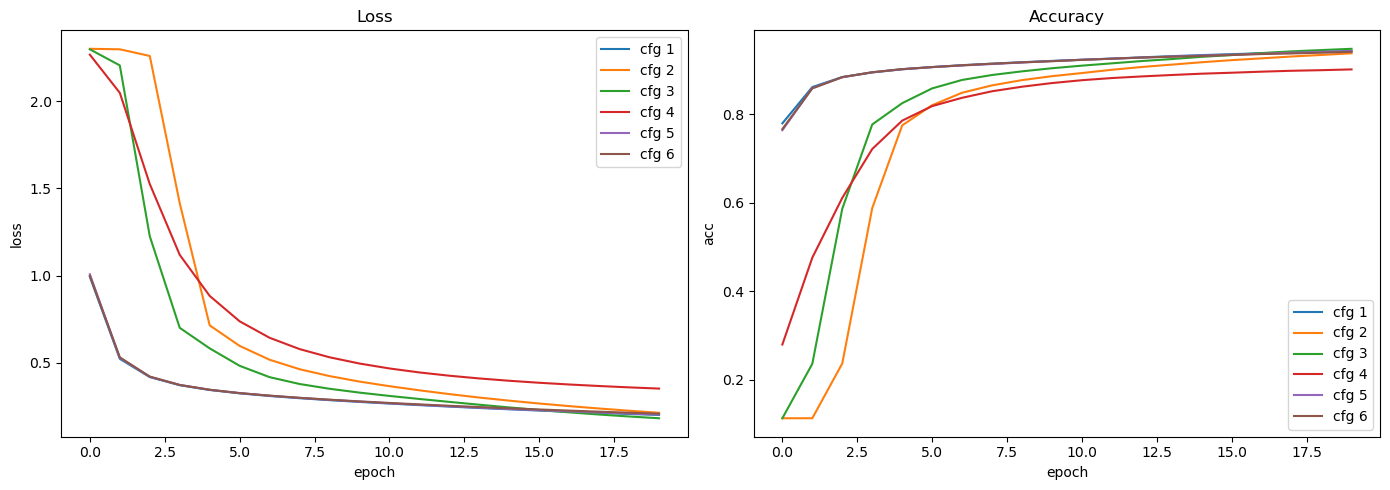

In [26]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# данные MNIST 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
x_test  = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0

y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

configs = [
    
    {'layers': [784, 128, 10],          'act': 'relu',  'reg': 'l2',  'lam': 0.002},
    {'layers': [784, 128, 64, 10],      'act': 'relu',  'reg': 'l2',  'lam': 0.002},
    {'layers': [784, 256, 128, 10],     'act': 'relu',  'reg': 'l2',  'lam': 0.002},
    {'layers': [784, 128, 10],          'act': 'sigmoid', 'reg': 'l2',  'lam': 0.002},
    {'layers': [784, 128, 10],          'act': 'relu',  'reg': 'l1',  'lam': 0.002},
    {'layers': [784, 128, 10],          'act': 'relu',  'reg': 'l1L2','lam': 0.002},
]

results = []

for idx, cfg in enumerate(configs, 1):
    print(f'\n── Конфигурация {idx}: {cfg}')
    
    # список функций активации: для всех скрытых одинаковая,
    # для выхода  softmax
    hidden_acts = [cfg['act'].lower()] * (len(cfg['layers']) - 2)
    activation_functions = hidden_acts + ['softmax']
    
    net = MyMLP(
        layer_sizes         = cfg['layers'],
        activation_functions= activation_functions,
        task_type           = 'classification',
        num_classes         = 10,
        regularization      = cfg['reg'],
        lambda_reg          = cfg['lam']
    )
    
    loss_hist, acc_hist = [], []
    for ep in range(20):
        net.fit(x_train, y_train, epochs=1, batch_size=64, learning_rate=0.01)
        
        # full-batch оценка
        y_pred = net.predict(x_train)
        cur_loss = net.compute_loss(y_pred, y_train)
        cur_acc  = np.mean(np.argmax(y_pred, 1) == np.argmax(y_train, 1))
        
        loss_hist.append(cur_loss)
        acc_hist .append(cur_acc )
        if (ep+1) % 5 == 0:
            print(f'  Эпоха {ep+1:2d}: loss = {cur_loss:.4f}, acc = {cur_acc:.4f}')
    
    results.append({'loss': loss_hist, 'acc': acc_hist})

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
for i,res in enumerate(results,1):
    plt.plot(res['loss'], label=f'cfg {i}')
plt.title('Loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend()

plt.subplot(1,2,2)
for i,res in enumerate(results,1):
    plt.plot(res['acc'], label=f'cfg {i}')
plt.title('Accuracy')
plt.xlabel('epoch'); plt.ylabel('acc'); plt.legend()

plt.tight_layout(); plt.show()

## Регресссия 

In [ ]:
# sklearn.datasets.fetch_california_housing()



=== Config 1: layers=[8, 64, 1], reg=none, λ=0.0 ===
Epoch   0  Loss: 0.9948
Epoch   0  Loss: 0.9779
Epoch   0  Loss: 0.9212
Epoch   0  Loss: 0.7793
Epoch   0  Loss: 0.6060
Epoch   0  Loss: 0.5121
Epoch   0  Loss: 0.4741
Epoch   0  Loss: 0.4545
Epoch   0  Loss: 0.4404
Epoch   0  Loss: 0.4282
Epoch 10 | Loss=0.4399 | R²=0.5512
Epoch   0  Loss: 0.4171
Epoch   0  Loss: 0.4069
Epoch   0  Loss: 0.3975
Epoch   0  Loss: 0.3890
Epoch   0  Loss: 0.3816
Epoch   0  Loss: 0.3752
Epoch   0  Loss: 0.3697
Epoch   0  Loss: 0.3651
Epoch   0  Loss: 0.3613
Epoch   0  Loss: 0.3581
Epoch 20 | Loss=0.3779 | R²=0.6145
Epoch   0  Loss: 0.3552
Epoch   0  Loss: 0.3527
Epoch   0  Loss: 0.3506
Epoch   0  Loss: 0.3488
Epoch   0  Loss: 0.3472
Epoch   0  Loss: 0.3457
Epoch   0  Loss: 0.3443
Epoch   0  Loss: 0.3430
Epoch   0  Loss: 0.3417
Epoch   0  Loss: 0.3406
Epoch 30 | Loss=0.3581 | R²=0.6346

=== Config 2: layers=[8, 128, 1], reg=l2, λ=0.001 ===
Epoch   0  Loss: 0.9881
Epoch   0  Loss: 0.9549
Epoch   0  Loss: 0

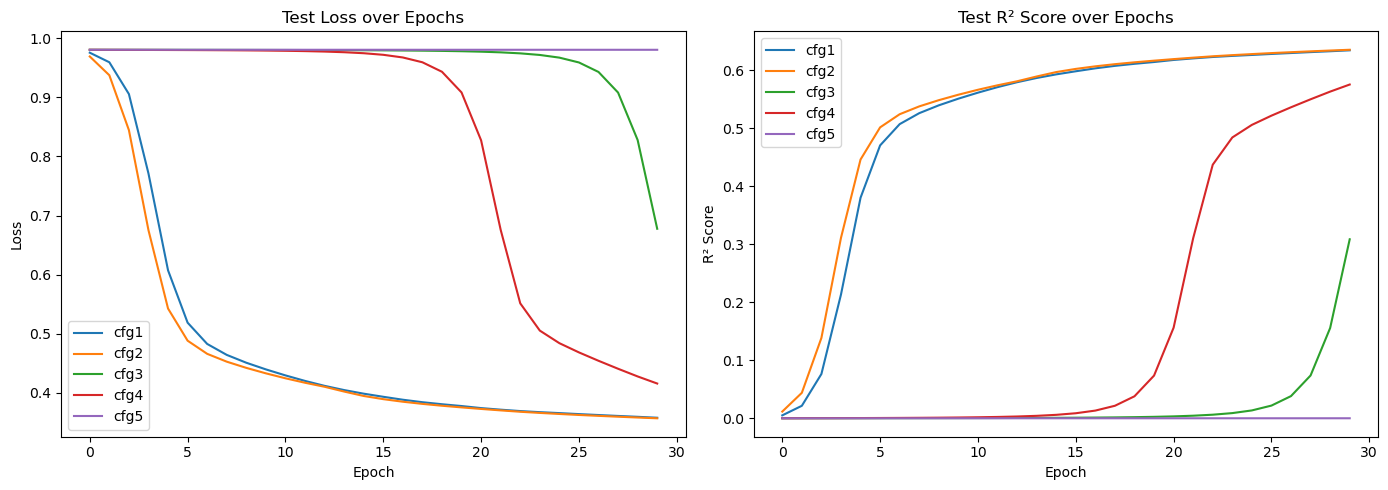

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_test  = scaler_X.transform(X_test)
y_train = scaler_y.transform(y_train)
y_test  = scaler_y.transform(y_test)

configs = [
    {'layers': [8,   64,     1],      'acts': ['relu','linear'],            'reg':'none',  'lam':0.0},
    {'layers': [8,   128,    1],      'acts': ['relu','linear'],            'reg':'l2',    'lam':0.001},
    {'layers': [8,   64, 32,  1],      'acts': ['relu','relu','linear'],     'reg':'l1',    'lam':0.001},
    {'layers': [8,   128, 64,  1],     'acts': ['relu','relu','linear'],     'reg':'l1l2',  'lam':0.001},
    {'layers': [8,   256,128,64,1],    'acts': ['relu','relu','relu','linear'],'reg':'l2',   'lam':0.0005},
]

results = []

# 3) Цикл по конфигурациям
for idx, cfg in enumerate(configs, start=1):
    print(f"\n=== Config {idx}: layers={cfg['layers']}, reg={cfg['reg']}, λ={cfg['lam']} ===")
    
    # Инициализируем сеть
    net = MyMLP(
        layer_sizes=cfg['layers'],
        activation_functions=cfg['acts'],
        task_type='regression',
        num_classes=None,
        regularization=cfg['reg'],
        lambda_reg=cfg['lam']
    )
    
    loss_hist = []
    r2_hist   = []
    
    epochs     = 30
    batch_size = 64
    lr         = 0.005
    
    for ep in range(epochs):
        net.fit(X_train, y_train,
                epochs=1,
                batch_size=batch_size,
                learning_rate=lr)
        
        # Оценка на тесте
        y_pred = net.predict(X_test)
        loss   = net.compute_loss(y_pred, y_test)
        r2     = r2_score(y_test, y_pred)
        
        loss_hist.append(loss)
        r2_hist.append(r2)
        
        if (ep+1) % 10 == 0:
            print(f"Epoch {ep+1:2d} | Loss={loss:.4f} | R²={r2:.4f}")
    
    results.append((loss_hist, r2_hist))

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1, 2, 1)
for i, (loss_hist, _) in enumerate(results, start=1):
    plt.plot(loss_hist, label=f'cfg{i}')
plt.title('Test Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# R2 Score
plt.subplot(1, 2, 2)
for i, (_, r2_hist) in enumerate(results, start=1):
    plt.plot(r2_hist, label=f'cfg{i}')
plt.title('Test R² Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()

plt.tight_layout()
plt.show()

###  Функции активации и их производные

#### ReLU:
$$
f(z) = \max(0, z) \\
f'(z) = \begin{cases}
1, & \text{если } z > 0 \\
0, & \text{если } z \leq 0
\end{cases}
$$

#### LReLU:
$$
f(z) = \begin{cases}
z, & \text{если } z > 0 \\
\alpha z, & \text{если } z \leq 0
\end{cases} \\
f'(z) = \begin{cases}
1, & \text{если } z > 0 \\
\alpha, & \text{если } z \leq 0
\end{cases}
$$

#### Sigmoid:
$$
f(z) = \frac{1}{1 + e^{-z}} \\
f'(z) = f(z)(1 - f(z))
$$

###  Регуляризация

#### L1 регуляризация:
$$
\frac{\partial R}{\partial W} = \lambda \cdot \text{sign}(W)
$$

#### L2 регуляризация:
$$
\frac{\partial R}{\partial W} = 2\lambda W
$$

#### L1L2 регуляризация:
$$
\frac{\partial R}{\partial W} = \lambda_1 \cdot \text{sign}(W) + 2\lambda_2 W
$$
